<a href="https://colab.research.google.com/github/tejaspradhan/Face-Generation-from-Textual-Features-using-GANs/blob/main/Pytorch_Text2Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

# StyleGAN

In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 138 (delta 4), reused 10 (delta 4), pack-reused 127
Receiving objects: 100% (138/138), 599.47 KiB | 1.39 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
%cd stylegan2/
!ls

/content/stylegan2/stylegan2
dataset_tool.py  LICENSE.txt		 README.md	   run_training.py
dnnlib		 metrics		 run_generator.py  test_nvcc.cu
Dockerfile	 pretrained_networks.py  run_metrics.py    training
docs		 projector.py		 run_projector.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import pickle

import pretrained_networks
from dnnlib import tflib as tflib
import numpy as np
import PIL.Image
import dnnlib
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Flatten
%matplotlib inline

In [ ]:
# loading pretrained network
G, D, Gs = pretrained_networks.load_networks('/content/drive/MyDrive/Text2Face/Models/stylegan2-ffhq-config-f.pkl')

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
truncation_psi=1.0
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation_psi is not None:
    Gs_kwargs.truncation_psi = truncation_psi

In [ ]:
seed =4000
print('Generating image for seed %d...' % (seed))
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:])
print("Noise Vars: ",noise_vars)
print("Input size: ",*Gs.input_shape[1:])
tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) 
images = Gs.run(z, None, **Gs_kwargs)
img=PIL.Image.fromarray(images[0], 'RGB')

Generating image for seed 4000...
Noise Vars:  [<tf.Variable 'G_synthesis_1/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise5:0' shape=(1, 1, 32, 32) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise6:0' shape=(1, 1, 32, 32) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise7:0' shape=(1, 1, 64, 64) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise8:0' shape=(1, 1, 64, 64) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise9:0' shape=(1, 1, 128, 128) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise10:0' shape=(1, 1, 128, 128) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise11:0' shape=(1, 1, 256, 256) dtype=float32_ref>, <t

In [ ]:
img.size

(1024, 1024)

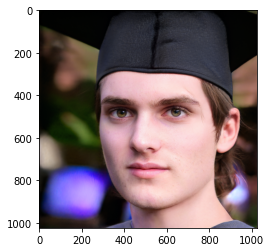

In [ ]:
imshow(img)

## Custom Methods

In [ ]:
def stylegan_generate_image(latent_vector):
  seed = np.random.randint(10000)
  #print('Generating image for seed %d...' % (seed))
  rnd = np.random.RandomState(seed)
  z = np.array([latent_vector])
  #print("Noise Vars: ",noise_vars)
  #print("Input size: ",*Gs.input_shape[1:])
  # print("Input: \n",latent_vector)
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) 
  images = Gs.run(z, None, **Gs_kwargs)
  img=PIL.Image.fromarray(images[0], 'RGB')
  #return np.array(img)
  return img

In [ ]:
def reconstruction_loss(real_images, generated_images):
  loss = []
  for real_image, fake_image in zip(real_images,generated_images):
    loss.append(0.5)
  #return tf.convert_to_tensor(loss,dtype=tf.float32)
  return loss

## Loading Data

In [ ]:
embeddings = np.load('/content/drive/MyDrive/Text2Face/Dataset/embeddings/embeddings_37k.npz')['arr_0']

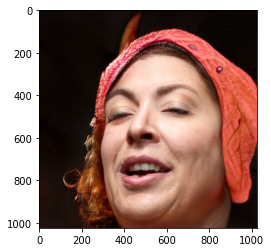

In [ ]:
img =stylegan_generate_image(embeddings[10])
imshow(img)

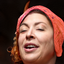

In [ ]:
resize_image(img)

In [ ]:
print(img.size)

(1024, 1024)


In [ ]:
face_data = pd.read_csv('/content/drive/MyDrive/Text2Face/Dataset/face_features_csv/face_features_preprocessed.csv')

In [ ]:
face_ids=face_data['image_id']

In [ ]:
face_ids.shape

(202599,)

In [ ]:
embeddings.shape

(37370, 512)

## Training 

In [ ]:
from PIL import Image

In [ ]:
BATCH_SIZE =32
NO_OF_BATCHES=BATCH_SIZE*4

In [ ]:
def get_images(face_ids):
  images=[]
  for id in face_ids:
    print(id)
    img = cv2.imread('/content/drive/MyDrive/Text2Face/Dataset/celebA/'+id[:-4]+".png")
    img=img[...,::-1]
    images.append(img)
  images= np.array(images)
  return images

In [ ]:
get_images([face_ids[0]])[0].shape

000001.jpg


(256, 256, 3)

000002.jpg


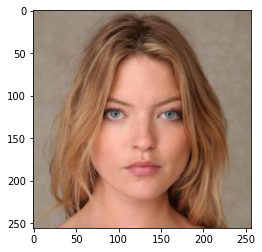

In [ ]:
imshow(get_images([face_ids[1]])[0])

## Defining Intermediate Trainable Model

In [ ]:
# model = tf.keras.models.Sequential()
# model.add(Conv1D(64,3, input_shape =(512,1)))
# model.add(MaxPool1D(2))
# model.add(Flatten())
# model.add(Dense(512,activation='relu'))

### Pytorch

In [ ]:
import torch
from torch import nn

In [ ]:
# Trying out torch stuff
x1=torch.ones(2,2,3)
print("x1: ",x1)
x2=torch.zeros(2,2,3)
print("x2: ",x2)

x1:  tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])
x2:  tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])


In [ ]:
x2-x1

tensor([[[-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.]]])

In [ ]:
torch.mean(x2-x1)

tensor(-1.)

In [ ]:
def resize_image(img, target_width=64):
  mywidth = target_width
  wpercent = mywidth/float(img.size[0])
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
  return np.array(img)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten(start_dim=512, end_dim=512)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=512, end_dim=512)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
  )
)


In [ ]:
print(model.children)

<bound method Module.children of NeuralNetwork(
  (flatten): Flatten(start_dim=512, end_dim=512)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
  )
)>


In [ ]:
def my_loss(output, target):
    output=resize_image(output,256)
    loss=np.mean(output-target)
    print(loss)
    loss = torch.tensor([loss],requires_grad=True,dtype=torch.float16)
    #loss=torch.tensor([10.5],requires_grad=True,dtype=torch.float16)
    return loss

In [ ]:
EPOCHS=5
NO_OF_INPUT=10

In [ ]:
images=get_images(face_ids[:NO_OF_INPUT])
images.shape

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


(10, 256, 256, 3)

In [ ]:
embeddings=embeddings[:NO_OF_INPUT]
embeddings.shape

(10, 512)

In [ ]:
#G
#model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(EPOCHS):
  print('Epoch: ',i)
  for image, embedding in zip(images,embeddings):
    optimizer.zero_grad()
    #print(embedding)
    ip=torch.Tensor(embedding)
    model_op=model(ip)
    
    model_op1=model_op.clone().detach().numpy()
    model_op1=model_op1.tolist()
    #print(model_op1)
    op_image=stylegan_generate_image(model_op1)
    imshow(op_image)
    loss=my_loss(op_image,image)
    loss.backward()
    optimizer.step()
  if i%2==0:
    print("Saving Model......")
    torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/Text2Face/Models/model--loss_'+str(loss.item())+'--epoch_'+str(i)+'.pt')

## The End